In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import sys
import pickle
import gzip
import functools
import operator
import glob

sys.path.append("scripts/")
import scripts.conf as conf
from scripts.evaluate_performance import comparison_main
import scripts.oncotree
conf.config_params()
oncotree = scripts.oncotree.Oncotree()

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc

from fetch_data_needle import create_observed_dataset, get_mutations, get_plot_data
from plot_needle import plot_observed_distribution

# Figure 1a

In [3]:
obs_muts = get_mutations()

def needleplot(gene, ttype, plotname=None):
    df = create_observed_dataset(gene, ttype, obs_muts)
    args = get_plot_data(df)
    plot_observed_distribution(gene, ttype, *args, plotname=plotname)

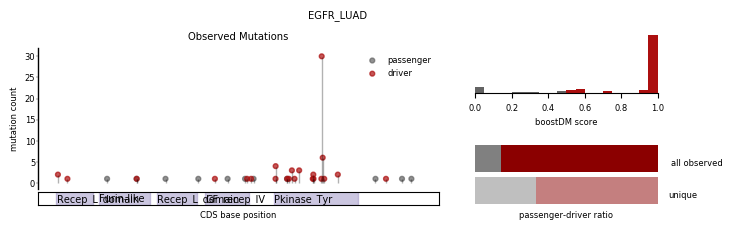

In [4]:
gene, ttype = 'EGFR', 'LUAD'
needleplot(gene, ttype, plotname=f'./raw_plots/{gene}.{ttype}')

# Figure 1c

In [5]:
if not(os.path.exists("source_data/model_selection_information.tsv")):
    ! python3 scripts/create_table_stats_models.py source_data/model_selection_information.tsv

In [6]:

def is_specific(gene, ttype, model_dict):
    """
    asserts whether the model employed for gene-ttype
    is specific -- has been fitted with mutations 
    strictly from the gene-ttype -- or not.

    it uses model_dict, an instance externally defined
    with the boostdm models
    """

    model = model_dict.get((ttype, gene), None)
    if (ttype, gene) == model:
        return True
    else:
        return False

    
    
def is_cancer_specific(ttype):
    ttypes=oncotree.get_ttypes(ttype)
    if len(ttypes) == 1 and ttypes[0] == ttype:
        return True
    return False
    
def plot_discovery_vs_performance_size(df,x_column,y_column,y_error_c,x_error_c,selected_column,cancer_specific,xlabel = "", ylabel = "", title='Mutational discovery index and boostdm performance', highlight_genes=None, density=None, saveplot=False,name_plot="",size_column="",xlim=None,m_x=None,m_y=None):
    highlight_gene_ttypes_coord,highlight_gene_ttypes_size = {}, {}
    highlight_gene_ttypes_role = {}
    x, y, y_error,x_error, s, c, role, selected,ec = [], [], [], [], [], [], [], [], []
    for i,r in df.iterrows():
        if cancer_specific and is_cancer_specific(r["ttype"]):
            x.append(r[x_column])
            y.append(r[y_column])
            x_error.append([r[x_column]-r[x_error_c[0]],r[x_error_c[1]]-r[x_column]])
            y_error.append([r[y_column]-r[y_error_c[0]],r[y_error_c[1]]-r[y_column]])
            role.append(r["ROLE"])
            sel = r[selected_column]
            selected.append(sel)
            if sel:
                s.append(50)#s.append(r[size_column])
                c.append(conf.dict_colors_role[r["ROLE"]])
                ec.append("black")
            else:
                c.append("grey")
                ec.append("grey")
                s.append(25)#s.append(r[size_column])
        
        if highlight_genes is not None:
                k=(r["ttype"],r["gene"])
                if (r["ttype"],r["gene"]) in highlight_genes:
                    highlight_gene_ttypes_coord[k] = y[-1], x[-1]
                    highlight_gene_ttypes_role[k] = r["ROLE"]
                    highlight_gene_ttypes_size[k] = 50 #r[size_column]
                    print(f'{r["gene"]}: {r["ttype"]}: discovery index: {y[-1]} performance f-score50 {x[-1]}')

    fig, ax = plt.subplots(figsize=(6.5, 7))
    gs = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[15,2], height_ratios=[2, 15])
    gs.update(hspace=0.0, wspace=0.00)

    ax0 = plt.subplot(gs[0]) # density top
    ax1 = plt.subplot(gs[1]) # null
    ax2 = plt.subplot(gs[2], sharex=ax0) # scatter
    ax3 = plt.subplot(gs[3], sharey=ax2) # density

    # ax0: density plot: oncogenes vs tumor suppressors
    
    
    bandwidth = 0.03
    alpha = 0.25
    x_lof = [u for i, u in enumerate(x) if role[i] == 'LoF' ]
    x_act = [u for i, u in enumerate(x) if role[i] == 'Act']
    x_amb = [u for i, u in enumerate(x) if (role[i] == 'ambiguous' or str(role[i]) == "nan") ]

    y_lof = [u for i, u in enumerate(y) if role[i] == 'LoF' ]
    y_act = [u for i, u in enumerate(y) if role[i] == 'Act']
    y_amb = [u for i, u in enumerate(y) if role[i] == 'ambiguous' ]

    bandwidth = 0.2
    alpha = 0.25
    sns.distplot(x_lof, hist=False, kde=True, color=conf.dict_colors_role['LoF'], 
                         kde_kws={'linewidth': 2, 'bw': bandwidth, 'alpha': alpha}, 
                         ax=ax0, vertical=False)
    sns.distplot(x_act, hist=False, kde=True, color=conf.dict_colors_role['Act'], 
                         kde_kws={'linewidth': 2, 'bw': bandwidth, 'alpha': alpha}, 
                         ax=ax0, vertical=False)

    # ax1: scatter plot
   
    # x 
    x_lof = [u for i, u in enumerate(x) if role[i] == 'LoF' and selected[i]]
    x_act = [u for i, u in enumerate(x) if role[i] == 'Act' and selected[i]]
    x_amb = [u for i, u in enumerate(x) if (role[i] == 'ambiguous' or str(role[i]) == "nan") and selected[i]]
    x_nonsel = [u for i, u in enumerate(x) if not(selected[i])]

    # y 
    y_lof = [u for i, u in enumerate(y) if role[i] == 'LoF' and selected[i]]
    y_act = [u for i, u in enumerate(y) if role[i] == 'Act' and selected[i]]
    y_amb = [u for i, u in enumerate(y) if role[i] == 'ambiguous' and selected[i]]
    y_nonsel = [u for i, u in enumerate(y) if not(selected[i])]
    
    # x error
    x_error_lof = [u for i, u in enumerate(x_error) if role[i] == 'LoF'  and selected[i]]
    x_error_act = [u for i, u in enumerate(x_error) if role[i] == 'Act'  and selected[i]]
    x_error_amb = [u for i, u in enumerate(x_error) if role[i] == ('ambiguous' or str(role[i]) == "nan")  and selected[i]]
    x_error_nonsel = [u for i, u in enumerate(x_error) if not(selected[i])]
    
    # y error
    y_error_lof = [u for i, u in enumerate(y_error) if role[i] == 'LoF' and selected[i]]
    y_error_act = [u for i, u in enumerate(y_error) if role[i] == 'Act'  and selected[i] ]
    y_error_amb = [u for i, u in enumerate(y_error) if (role[i] == 'ambiguous' or str(role[i]) == "nan")  and selected[i]]
    y_error_nonsel = [u for i, u in enumerate(y_error) if not(selected[i])]
    
    ax2.fill_between(x=[0,m_x],y1=[m_y,m_y],y2=[1.01,1.01],color="#fdcdac")
    ax2.scatter(x,y,s=s,c=c,alpha=0.9,edgecolors=ec,lw=1.)
    
    scatter_kwargs = {"alpha":1.,"markeredgecolor":"black","markeredgewidth":0.5,"markersize":0}
    elinew=0.3

    ax2.errorbar(x_lof, y_lof,  yerr=np.array(y_error_lof).T, capsize=0 ,elinewidth=elinew,fmt='o',color=conf.dict_colors_role["LoF"],**scatter_kwargs)
    ax2.errorbar(x_act, y_act, yerr=np.array(y_error_act).T,  capsize=0 ,elinewidth=elinew,fmt='o',color=conf.dict_colors_role["Act"],**scatter_kwargs)
    ax2.errorbar(x_amb, y_amb, yerr=np.array(y_error_amb).T,  capsize=0 ,elinewidth=elinew,fmt='o',color=conf.dict_colors_role["ambiguous"],**scatter_kwargs)
    
    scatter_kwargs = {"alpha":1.0,"markeredgecolor":"black","markeredgewidth":0.5,"markersize":0}
    elinew=0.3
    ax2.errorbar(x_nonsel, y_nonsel,  capsize=0 ,elinewidth=elinew ,fmt='o',color="grey", yerr=np.array(y_error_nonsel).T,**scatter_kwargs) #  

    
    if m_x:
        ax2.vlines(m_x,0.8,1,color="grey",linestyles='dashed' , lw= 1.0)
    if m_y:
        ax2.hlines(m_y,0,1.05,color="grey",linestyles='dashed' , lw= 1.0)
        ax2.hlines(0.8, 0, 1, color='grey',linestyles='dashed' , lw= 2.5) 
    else:
        ax2.hlines(0.8, 0, 1, color='grey', linestyles='dashed' , lw= 1.0) 
    ax2.set_ylabel(ylabel,fontsize=12)
    ax2.set_xlabel(xlabel,fontsize=12)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)


    if highlight_genes is not None:
        for k, v in highlight_gene_ttypes_coord.items():
            ax2.text(v[1] + np.random.uniform(low=0, high=0.05, size=1), v[0], 
                     f'{k[1]} ({k[0]})',fontsize=10)
            ax2.scatter([v[1]], [v[0]], 
                        s=highlight_gene_ttypes_size[k], 
                        marker='o', color=conf.dict_colors_role[highlight_gene_ttypes_role[k]], edgecolors='black',lw=2)

    ax0.axis('off')
    ax1.axis('off')
    ax3.axis('off')

    if density is None:
        ax0.set_title(title)
    else:
        ax2.set_title(title)

    if "log" in y_column:
        ax2.set_yticklabels([int(2**x) for x in ax2.get_xticks()])
    if xlim:
        ax0.set_xlim(xlim)
        ax2.set_xlim(xlim)
    ax0.set_xlim(-0.05,1.05)
    ax2.set_xlim(-0.05,1.05)
    
    
    ax2.set_ylim(0.5,1.05)

    # create legend
    
    markers = [plt.Line2D([0,0],[0,0],color=conf.dict_colors_role["LoF"], marker='o', linestyle=''),
               plt.Line2D([0,0],[0,0],color=conf.dict_colors_role["Act"], marker='o', linestyle=''),
               plt.Line2D([0,0],[0,0],color=conf.dict_colors_role["Amb"], marker='o', linestyle='solid',lw=1.,markeredgecolor="black"),
               plt.Line2D([0,0],[0,0],color="grey", marker='o', linestyle='')]
    ax2.legend(markers, [f"{len(x_lof)} tumor supressor models",f"{len(x_act)} oncogene models",f"{len(x_amb)} ambiguous models",f"{len(x_nonsel)} non-selected models"], 
               numpoints=1,loc =(0.8,0.05),facecolor=None )
    
    if saveplot:
        plt.savefig(f'./raw_plots/{name_plot}.pdf', dpi=800,bbox_inches="tight")
        plt.savefig(f'./raw_plots/{name_plot}.png', dpi=800,bbox_inches="tight")

    plt.show()
    
    return y

def assign_quartile(row,a,b,d_values):
    if row[a] >= d_total[a] and row[b] >= d_values[b]:
        return "Other"
    if row[a] >= d_total[a] and row[b] < d_values[b]:
        return "Other"
    if row[a] < d_total[a] and row[b] >= d_values[b]:
        return "Q1"
    if row[a] < d_total[a] and row[b] < d_values[b]:
        return "Other"

### Figure 1c, Load data

In [7]:
data = pd.read_csv("source_data/model_selection_information.tsv",sep="\t")
selected = data[data["selected"]]

d_total = {}
d_total["discovery_index"]=np.percentile(selected["discovery_index"].values,50)
d_total["mean_fscore50"]=np.percentile(selected["mean_fscore50"].values,50)

d_values = {"discovery_index":np.nanmedian(selected["discovery_index"].values),"mean_fscore50":np.nanmedian(selected["mean_fscore50"].values)} 
data["quartile_di_vs_fscore"] = data.apply(lambda row: assign_quartile(row,"discovery_index","mean_fscore50",d_values),axis=1)
selected = data[data["selected"]]

### Figure 1c, render plot

RB1: BLCA: discovery index: 0.9663865546218487 performance f-score50 0.39123667996254097
TP53: COREAD: discovery index: 0.9114349922831072 performance f-score50 0.6187516006821946
CTNNB1: HC: discovery index: 0.9529945999018165 performance f-score50 0.8985311339391882


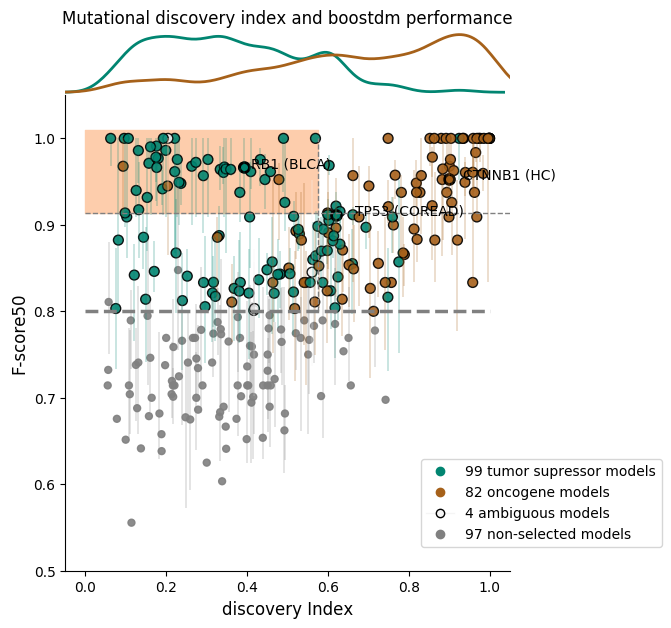

In [8]:
conf.config_params()
_=plot_discovery_vs_performance_size(data.drop_duplicates(),y_column="mean_fscore50",x_column="discovery_index",x_error_c=("discovery_low","discovery_high"),y_error_c=("up_fscore50","dn_fscore50"),cancer_specific=True,size_column="normalized_size",selected_column="selected",
                             ylabel="F-score50",xlabel="discovery Index",highlight_genes=[('COREAD', 'TP53'), ('BLCA', 'RB1'),   ('HC', 'CTNNB1')],saveplot=True,name_plot="d_index_vs_performance_q1",m_x=d_total["discovery_index"],m_y=d_total["mean_fscore50"])

### Figure 1c, render inner set plot

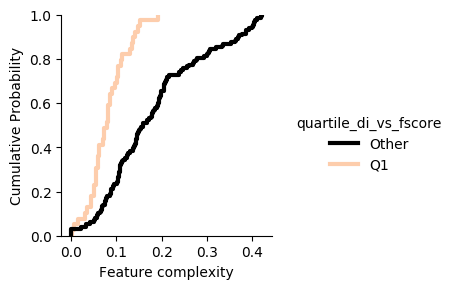

In [9]:
conf.config_params()

g=sns.displot(data=selected,x="linear_complexity",hue="quartile_di_vs_fscore",kind="ecdf",palette={"Q1":"#fdcdac","Other":"black"},lw=3.0,height=3)
g.set(xlabel='Feature complexity', ylabel='Cumulative Probability')
plt.savefig(f'./raw_plots/ecdf_q1_vs_other.pdf', dpi=800,bbox_inches="tight")
plt.show()

# Figure 1d

Doing LoF...


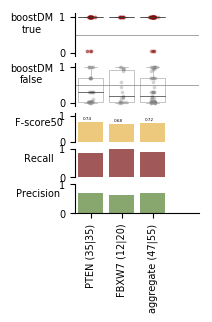

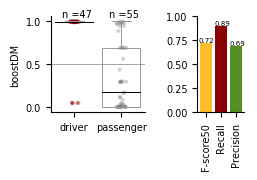

Doing Act...


<Figure size 640x480 with 0 Axes>

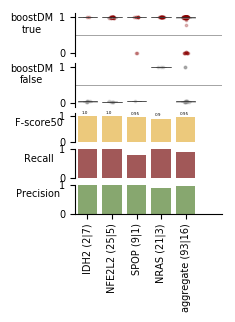

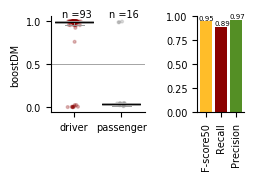

In [10]:
outpath = './raw_plots/'

file = os.path.join(os.environ['PATH_SOURCE_DATA'], 'figure1-source-data', 'kim_new.tsv')
predictions = os.path.join(os.environ['PATH_SOURCE_DATA'], 'boostdm-output-holdout', 'prediction_kim')
true_label = "functional"
false_label = "neutral"
csqn_type = 'missense'
label = "kim"

comparison_main(file, outpath,  true_label, false_label, csqn_type, label, predictions)

Doing LoF...


<Figure size 640x480 with 0 Axes>

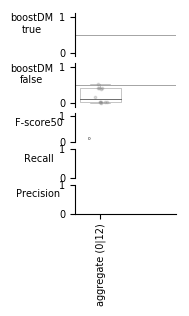

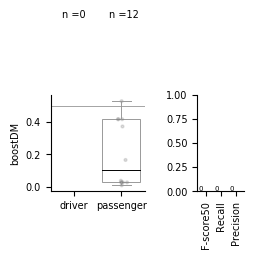

Doing Act...


<Figure size 640x480 with 0 Axes>

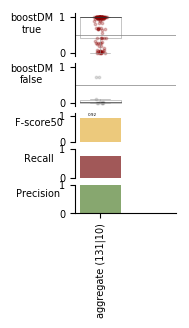

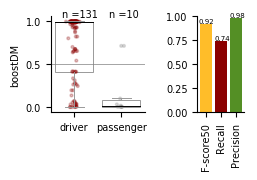

In [11]:
file = os.path.join(os.environ['PATH_SOURCE_DATA'], 'figure1-source-data', 'berger_new.tsv')
predictions = os.path.join(os.environ['PATH_SOURCE_DATA'], 'boostdm-output-holdout', 'prediction_berger')

true_label = "Driver"
false_label = "Passenger"
csqn_type = 'missense'
label = "berger"

comparison_main(file, outpath,  true_label, false_label, csqn_type, label, predictions)

# Figure 1e

In [12]:
method_label = {'boostDM_score': 'boostDM',
                'chasm_score': 'CHASMplus',
                'cadd_score': 'CADD',
                'tp53_kato': 'TP53 (Kato et al.)',
                'tp53_giacomelli': 'TP53 (Giacomelli et al.)',
                'vest4': 'VEST4',
                'sift': 'SIFT',
                'sift4g': 'SIFT4G',
                'Polyphen2_HVAR': 'Polyphen2 (HVAR)',
                'Polyphen2_HDIV': 'Polyphen2 (HDIV)',
                'fathmm': 'FATHMM',
                'MutationAssessor': 'MutationAssessor'
                }

palette_boostdm = {'boostDM_score': '#ac0f0f', 'boostDM_score_strict': '#ad6f0f'}
palette_bioinfo = dict(zip(['chasm_score', 'cadd_score', 'vest4', 'sift', 'sift4g', 'Polyphen2_HVAR', 'Polyphen2_HDIV', 
                            'fathmm', 'MutationAssessor'], 
                           ['pink', '#b491c8', '#1565c0', '#663a82', '#1e88e5', '#90caf9', 'black', '#3c1361', '#52307c', ]))
palette_experimental = dict(zip(['tp53_kato', 'tp53_giacomelli', 'pten_mighell', 'ras_bandaru'],
                                ['#607c3c', '#b5e550', '#ececa3', '#abc32f']))

palettes = {}
palettes.update(palette_boostdm)
palettes.update(palette_bioinfo)
palettes.update(palette_experimental)

cv_path = os.path.join(os.environ['PATH_SOURCE_DATA'], 'benchmark-cvdata')

In [13]:
# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0.5, 1.01)
    

@trycatch
def plot_prc(gene, ttype, score, ax=None, plot=True, **kwargs):
    
    if score in ['chasm_score']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_chasm/{gene}.{ttype}.cv_chasm.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df[score] != '.') & (~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['cadd_score']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_cadd/{gene}.{ttype}.cv_cadd.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[~df[score].isnull()]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['boostDM_score']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_boostdm/{gene}.{ttype}.cv_boostdm.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['tp53_kato']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_tp53_kato/{gene}.{ttype}.cv_tp53.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df['tp53_score'].isnull())]
        X = df['tp53_score'].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['pten_mighell']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_pten_mighell/{gene}.{ttype}.cv_pten.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['ras_bandaru']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_ras_bandaru/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df['ras_score'].isnull())]
        X = df['ras_score'].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['tp53_giacomelli']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_tp53_giacomelli/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(~df['tp53_natgen_score'].isnull())]
        X = df['tp53_natgen_score'].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['sift']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df['SIFT'] != '.') & (~df['SIFT'].isnull())]
        X = df['SIFT'].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['sift4g']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df['SIFT4G'] != '.') & (~df['SIFT4G'].isnull())]
        X = df['SIFT4G'].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['Polyphen2_HDIV']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df[score] != '.') & (~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
    
    elif score in ['Polyphen2_HVAR']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df[score] != '.') & (~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['fathmm']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df['FATHMM'] != '.') & (~df['FATHMM'].isnull())]
        X = df['FATHMM'].values.reshape(-1, 1)
        y = df['driver'].values
        
    elif score in ['MutationAssessor']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df[score] != '.') & (~df[score].isnull())]
        X = df[score].values.reshape(-1, 1)
        y = df['driver'].values

    elif score in ['vest4']:
        with gzip.open(os.path.join(cv_path, 
                                    f'cv_{score}/{gene}.{ttype}.pickle.gz'), 
                       'rb') as g:
            tables = pickle.load(g)
        df = pd.concat(tables, axis=0)
        df = df[(df['VEST4'] != '.') & (~df['VEST4'].isnull())]
        X = df['VEST4'].values.reshape(-1, 1)
        y = df['driver'].values
        
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    
    # number of mutations
    n = len(y)
    positive = sum(y)
    negative = n - positive
    
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, probs)
    auc_score = auc(recall, precision)

    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, probs, ax, label=f'{method_label[score]}: auPRC={auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, positive, negative


def plot_tp53_boxplot():
    
    gene = 'TP53'
    fig, ax = plt.subplots(figsize=(10, 3))
    tumor_types = {'PRAD', 'ESCA', 'LUSC', 'LUAD', 'UCEC', 'PAAD', 'OV', 'BLCA', 'GBM'}
    
    scores, scores_full = zip(*list(method_label.items()))
        
    box = [[] for _ in scores]
    for ttype in tumor_types:
        for i, score in enumerate(scores):
            auc, _, _, _, _ = plot_prc(gene, ttype, score, ax=ax, plot=False, lw=4, alpha=1)
            box[i].append(auc)
    
    sorted_index = np.argsort(list(map(np.nanmedian, box)))[::-1]
    box = [box[i] for i in sorted_index]
    scores_full = [scores_full[i] for i in sorted_index]
    
    
    ax.boxplot(box, showfliers=False)
    x = [[i+1] * len(b) for i, b in enumerate(box)]
    x = functools.reduce(operator.concat, x)
    x = np.array(x) + np.random.normal(0, 0.05, size=len(x))
    
    colors = [[palettes[scores[sorted_index[i]]]] * len(b) for i, b in enumerate(box)]
    colors = functools.reduce(operator.concat, colors)
    y = functools.reduce(operator.concat, box)
    ax.scatter(x, y, c=colors, s=30)
    ax.set_ylabel('auPRC')
    ax.set_xlabel('Method')
    ax.set_xticklabels(scores_full, rotation=90)
    ax.set_title('Performance in TP53 across tumor-types')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('./raw_plots/TP53.boxplot.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    
def plot_tp53_bioinfo(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(4,4))
    lw = 4
    alpha = 0.8
    plot_prc(gene, ttype, 'boostDM_score', ax=ax, color=palettes['boostDM_score'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'chasm_score', ax=ax, color=palettes['chasm_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'cadd_score', ax=ax, color=palettes['cadd_score'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'sift4g', ax=ax, color=palettes['sift4g'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'vest4', ax=ax, color=palettes['vest4'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'Polyphen2_HDIV', ax=ax, color=palettes['Polyphen2_HDIV'], lw=lw, alpha=0.5)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'{gene} ({ttype})')
    ax.legend(loc=(0.5, 0.3))
    plt.savefig(f'./raw_plots/{gene}.{ttype}.prc.bioinfo.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    
def plot_tp53_experimental(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(4,4))
    lw = 4
    alpha = 0.8
    plot_prc(gene, ttype, 'boostDM_score', ax=ax, color=palettes['boostDM_score'], lw=5, alpha=1)
    plot_prc(gene, ttype, 'tp53_kato', ax=ax, color=palettes['tp53_kato'], lw=lw, alpha=alpha)
    plot_prc(gene, ttype, 'tp53_giacomelli', ax=ax, color=palettes['tp53_giacomelli'], lw=lw, alpha=alpha)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'{gene} ({ttype})')
    ax.legend(loc=(0.5, 0.3))
    plt.savefig(f'./raw_plots/{gene}.{ttype}.prc.experimental.svg', dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 640x480 with 0 Axes>

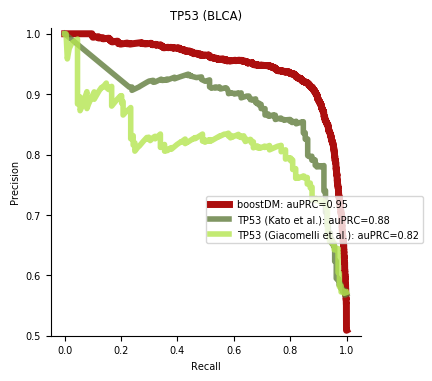

In [14]:
plot_tp53_experimental('TP53', 'BLCA')

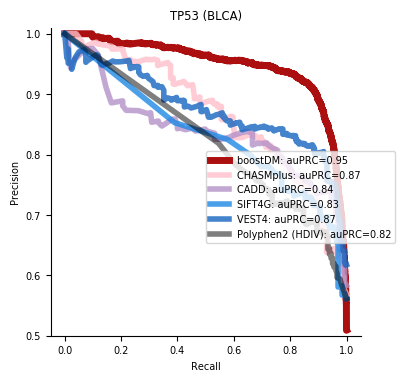

In [15]:
plot_tp53_bioinfo('TP53', 'BLCA')

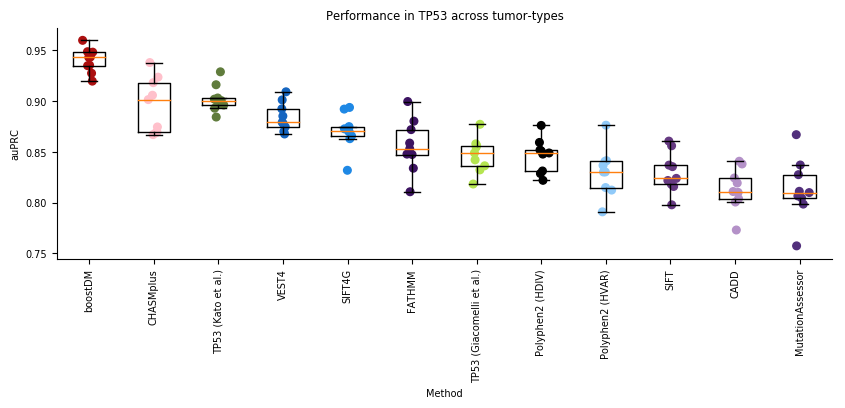

In [16]:
plot_tp53_boxplot()

## Figure 1f

In [17]:
highlighted = {
    'cadd': [('KRAS', 'PAAD'), ('EGFR', 'LUAD'), ('CTNNB1', 'HC'), ('FOXA1', 'PRAD'), ('TP53', 'BLCA')],
    'chasm': [('AR', 'PRAD'), ('EGFR', 'LUAD'), ('FOXA1', 'PRAD'), ('TP53', 'BLCA')],
    'ras_bandaru': [('NRAS', 'CM'), ('NRAS', 'MM'), ('NRAS', 'COREAD'), 
                    ('KRAS', 'CH'), ('KRAS', 'COREAD'), ('KRAS', 'LUAD'), 
                    ('KRAS', 'PAAD'), ('KRAS', 'ALL'), ('KRAS', 'MM'), 
                    ('HRAS', 'BLCA'), ('HRAS', 'HNSC')],
    'sift4g': [('KRAS', 'PAAD'), ('EGFR', 'LUAD'), ('PIK3CA', 'UCEC'), ('FOXA1', 'PRAD'), ('TP53', 'BLCA')]
}

In [18]:
def scatter_fscore(score):

    fig, ax = plt.subplots(figsize=(4,4))

    boostdm, method = {}, {}
    
    if score in ['chasm', 'cadd']:
        glob_fn = os.path.join(cv_path, f'cv_{score}', f'*.*.cv_{score}.pickle.gz')
        color_label = f'{score}_score'
        prc_arg = f'{score}_score'
    
    elif score in ['sift4g', 'ras_bandaru']:
        glob_fn = os.path.join(cv_path, f'cv_{score}', f'*.*.pickle.gz')
        color_label = score
        prc_arg = score
    
    for fn in glob.glob(glob_fn):
        gene, ttype = tuple(os.path.basename(fn).split('.')[:2])
        x = plot_prc(gene, ttype, 'boostDM_score', ax=ax, plot=False)
        y = plot_prc(gene, ttype, prc_arg, ax=ax, plot=False)
        if (x is None) or (y is None):
            continue
        boostdm[(gene, ttype)] = x
        method[(gene, ttype)] = y
    
    aucs_boostdm = {k: s[0] for k, s in boostdm.items() if (s[3] >= 200) and (s[4] >= 200)}
    aucs_method = {k: s[0] for k, s in method.items() if (s[3] >= 200) and (s[4] >= 200)}
    labels = set(aucs_boostdm.keys()).intersection(set(aucs_method.keys()))
    y = [aucs_method[k] for k in labels]
    x = [aucs_boostdm[k] for k in labels]
    ax.scatter(x, y, s=200, alpha=0.5, color=palettes[color_label])
    for i, l in enumerate(labels):
        if l in highlighted[score]:
            ax.text(x[i], y[i], f'{l[0]} ({l[1]})')
            ax.scatter([x[i]], [y[i]], s=200, color='white', edgecolor='black')
    ax.plot([0.85, 1], [0.85, 1], '--', c='r', lw=4)
    ax.set_ylabel(f'{score.upper()} (auPRC)')
    ax.set_xlabel('boostDM (auPRC)')
    ax.set_xlim(0.84, 1.01)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig(f'./raw_plots/boostdm_vs_{score}.prc.global.svg', dpi=200, bbox_inches='tight')
    plt.show()

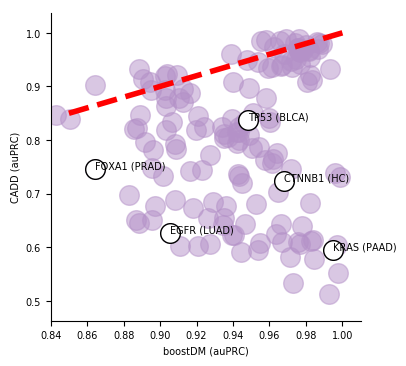

In [19]:
scatter_fscore('cadd')

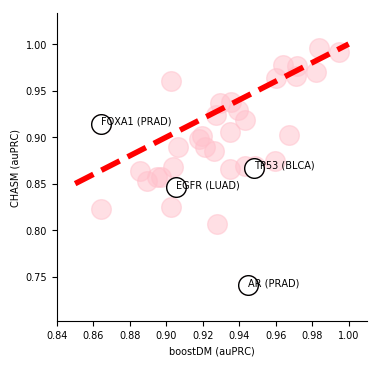

In [20]:
scatter_fscore('chasm')

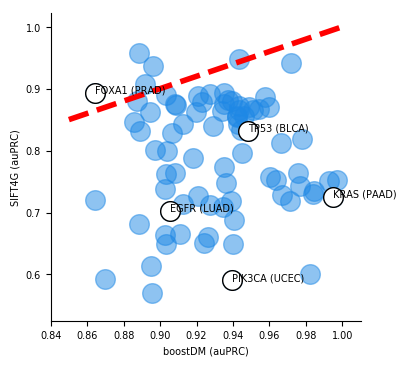

In [21]:
scatter_fscore('sift4g')

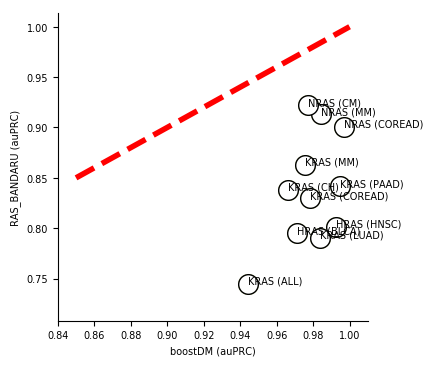

In [22]:
scatter_fscore('ras_bandaru')